# LIT-PCBA 
this dataset is a proposed "more difficult" test than DUD-E. I used a 75/25 (sklearn default) stratified split. The dataset is heavily imbalanced, like DUD-E.

In [1]:
import pickle
from sklearn.metrics import roc_auc_score
import numpy as np
import seaborn as sns
import torch
import seaborn as sns
from tqdm import tqdm
import pandas as pd
from pathlib import Path
from sklearn.metrics import f1_score, recall_score
import matplotlib.pyplot as plt
import sys
# sys.path.append('..')
sys.path.insert(0, "/g/g13/jones289/workspace/hd-cuda-master")
# print(sys.path)
import hdpy
import hdpy.ecfp
from hdpy.analysis import load_pkl
from hdpy.metrics import compute_enrichment_factor
from pathlib import Path


plt.rc('text', usetex=True)
plt.rc('font', family='serif')
plt.rc('xtick', labelsize=15)
plt.rc('ytick', labelsize=15)
plt.rc('axes', labelsize=17)
plt.rc('figure', titlesize=20)


# SEED=125
SEED=5
# SEED=2

# Todo: visualize the learning curves 

In [2]:
data_p = Path(f"/p/vast1/jones289/hd_results/{SEED}")

In [3]:
green_color_pal = sns.color_palette("Greens", 10)
blue_color_pal = sns.color_palette("Blues", 10)
rocket_color_pal = sns.color_palette("rocket", 10)

In [4]:
model_dict = {
    "hdbind-rp-molformer": ("HDBind+MolFormer", rocket_color_pal[0]),
    "hdbind-rp-ecfp-1024-1": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "hdbind-rp-ecfp-1024-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "hdbind-rp-ecfp-1024-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "hdbind-rp-ecfp-2048-1": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "hdbind-rp-ecfp-2048-2": ("HDBind+ECFP-1024-1", rocket_color_pal[2]),
    "hdbind-rp-ecfp-2048-4": ("HDBind+ECFP-1024-1", rocket_color_pal[2])

#     "smiles-pe.atomwise.0": rocket_color_pal[2],
#     "smiles-pe.bpe.0": rocket_color_pal[4],   
# "selfies.atomwise": green_color_pal[4],
#     "ecfp": green_color_pal[6],
#     "rp": green_color_pal[8],
#     "rf": blue_color_pal[4],
#     "mlp": blue_color_pal[7],
#     "HDC-MLP": green_color_pal[9],
#     "HDC-RF": green_color_pal[9],
#     "Vina": "salmon",
}


# model_order_list = [
#     ("hdbind-rp-molformer", )
#     ("smiles-pe.atomwise.0", "MoleHD-Atomw."),
#     ("smiles-pe.bpe.0", "MoleHD-BPE"),
#     ("smiles-pe.ngram.1", "SMILES uni-gram"),
#     ("selfies.atomwise", "HDBind-SELFIES"),
#     ("selfies.selfies-charwise", "SELFIES uni-gram"),
#     ("ecfp", "HDBind-ECFP"),
#     ("rp", "HDBind-ECFP+RP"),
#     ("rf", "RF"),
#     ("mlp", "MLP"),
#     ("Vina", "Vina")
# ]


# model_name_dict = {
#     "hdbind-rp-molformer": "HDBind+MolFormer"
#     "smiles-pe.atomwise.0": "MoleHD-Atomw.", 
#     "smiles-pe.bpe.0": "MoleHD-BPE",
#     "smiles-pe.ngram.1": "SMILES uni-gram",
#     "selfies.atomwise": "HDBind-SELFIES",
#     "selfies.selfies-charwise": "SELFIES uni-gram",
#     "ecfp": "HDBind-ECFP",
#     "rp": "HDBind-RPFP",
#     "rf": "RF",
#     "mlp": "MLP",
#     "Vina": "Vina",
#     "HDC-MLP": "HDC-MLP",
#     "HDC-RF": "HDC-RF"
# }

# LIT-PCBA Results

export CONDA_ROOT=/usr/workspace/jones289/anaconda3-power #installed using the LC installer script
export PATH=$CONDA_ROOT/bin:$PATH
export CONDA_EXE=$CONDA_ROOT/bin/conda
ml load gcc/11
export PYTHONPATH=$PWD:$PYTHONPATH
source activate /usr/workspace/jones289/anaconda3-power/envs/opence-1.8.0

In [5]:
from sklearn.metrics import recall_score, precision_score, f1_score, roc_auc_score


def compute_metrics(y_pred, y_score, y_true, p):
    
    return {"precision": precision_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "recall": recall_score(y_pred=y_pred, y_true=y_true),
           "f1": f1_score(y_pred=y_pred, y_true=y_true, zero_division=0),
            "enrich": float(compute_enrichment_factor(scores=y_score, labels=y_true, n_percent=p)),            
           "roc": roc_auc_score(y_score=y_score, y_true=y_true)
           }


def aggregate_results(dataset, range_limit=10, multistep_initial_p=None, 
                      multistep_p_list=None, 
                      multistep_sklearn_model=None):
    

    model_metric_dict = {"model": [], "enrich": [], "p":[], "train_time":[], "test_time": [], "target": [],
                        "seed": [], "recall": [], "precision": [], "f1": [], 
#                          "roc": []
                        }
#     import ipdb
#     ipdb.set_trace()
    for model_name, model_tup in tqdm(model_dict.items(), total=len(model_dict), position=0):
                        
#         metric_list = []
#         encode_time_list = []
#         train_time_list = []
#         test_time_list = []
#         train_size_list = []
#         test_size_list = []
#         target_size_list = []
#         eta_list = []

        
#         if model not in ["HDC-MLP", "HDC-RF"]:
#             data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

#         elif model in ["HDC-MLP", "HDC-RF"]:
#         data_path_list = list(data_p.glob(f"{dataset}*{model_name}*pkl"))
        data_path_list = list(data_p.glob(f"{model_name}.{dataset}*.pkl"))
        print(f"{model_name}-{dataset}: {len(model_tup)}\t {len(data_path_list)}")

        
# #     '''

        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)
#             torch.load(path)
            
            target = path.name.split(".")[1]
            
            print(target, path, model_name)


#             import ipdb
#             ipdb.set_trace()
            print(len(model_data_dict))
            for seed in range(len(model_data_dict['trials'])):
                trial_dict = model_data_dict['trials'][seed]
#                 import pdb
#                 pdb.set_trace()
#                 print(model_data_dict[seed].keys())
#                 print(trial_dict.keys())
                y_test = model_data_dict["y_test"]
                x_test = model_data_dict["x_test"]
                actives_database = sum(y_test)
                database_size = y_test.shape[0]
                
#                 eta = None 
                

#                 if model in ["rf", "mlp"]:


#                     for p in [.01, .1]:

#                         sklearn_model = model_data_dict[seed]["model"]

#                         y_score = sklearn_model.predict_proba(x_test)[:, 1]            
#                         y_pred = sklearn_model.predict(x_test)
#                         enrich = compute_enrichment_factor(sample_scores=y_score, 
#                                                 sample_labels=y_test,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)

                
#                         metrics = compute_metrics(y_pred=y_pred, y_score=y_score, y_true=y_test)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(p)
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])

                        
#                 elif model.lower() in ["hdc-rf", "hdc-mlp"]:

#                     sklearn_result_file = Path(f"{data_p}/{dataset.replace('-', '_')}.{target}.{multistep_sklearn_model}.None.{ngram_order}.pkl")

#                     with open(sklearn_result_file, "rb") as handle:
#                         sklearn_result_dict = pickle.load(handle)

#                     target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"

#                     hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                     hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)

# #                     # filter the data
#                     idxs = np.flip(np.argsort(hdc_conf_scores.squeeze().cpu().numpy(), kind="stable"))

                    
#                     sample_n = int(multistep_initial_p * y_test.shape[0])
#                     samp_idxs = idxs[:sample_n]
                    

#                     x_test_samp = x_test[samp_idxs]
#                     y_test_samp = y_test[samp_idxs]
                                            
    
#                     for p in multistep_p_list:

#                         sklearn_model = sklearn_result_dict[seed]["model"]
            
#                         sklearn_scores_samp = sklearn_model.predict_proba(x_test_samp)[:, 1]                        
            
#                         y_pred = sklearn_model.predict(x_test_samp)
#                         enrich = compute_enrichment_factor(sample_scores=sklearn_scores_samp, 
#                                                 sample_labels=y_test_samp,
#                                                 n_percent=p, 
#                                                 actives_database=actives_database, 
#                                                 database_size=database_size)


#                         metrics = compute_metrics(y_pred=y_pred, y_score=sklearn_scores_samp, y_true=y_test_samp)
                
#                         model_metric_dict["model"].append(model)
#                         model_metric_dict["target"].append(target)
#                         model_metric_dict["enrich"].append(enrich)
#                         model_metric_dict["p"].append(round(multistep_initial_p * p, 2))
#                         model_metric_dict["seed"].append(seed)
#                         model_metric_dict["precision"].append(metrics["precision"])
#                         model_metric_dict["recall"].append(metrics["recall"])
#                         model_metric_dict["f1"].append(metrics["f1"])
# #                         model_metric_dict["roc"].append(metrics["roc"])
                    

#                 else:                  
                    
#                 target_test_hv_path = f"{hd_cache_dir}/{target}/test_dataset_hv.pth"
                
#                 hv_test = torch.load(target_test_hv_path, map_location="cpu")
#                 hdc_conf_scores = model_data_dict[seed]["model"].compute_confidence(hv_test)
                hdc_conf_scores = trial_dict["eta"]
                for p in [.01, .1]:

                    
                    metrics = compute_metrics(y_pred=trial_dict["y_pred"], 
                                              y_score=hdc_conf_scores, 
                                              y_true=model_data_dict["y_test"],
                                             p=p)
                
#                     model_metric_dict["model"].append(model)
                    model_metric_dict["target"].append(target)
#                     model_metric_dict["enrich-1"].append(metrics["enrich-1"])
#                     model_metric_dict["enrich-10"].append(metrics["enrich-10"])
                    model_metric_dict["enrich"].append(metrics["enrich"])
                    model_metric_dict["p"].append(p)
                    model_metric_dict["seed"].append(seed)
                    model_metric_dict["precision"].append(metrics["precision"])
                    model_metric_dict["recall"].append(metrics["recall"])
                    model_metric_dict["f1"].append(metrics["f1"])
#                     model_metric_dict["roc"].append(metrics["roc"])
                    model_metric_dict["model"].append(model_name)

#                 #TODO: implement this 
#                 model_metric_dict["train_time"].append(train_time)
#                 model_metric_dict["test_time"].append(test_time)

    return model_metric_dict
        


In [6]:
model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)
# dude_model_metric_dict = aggregate_results(dataset="dude",multistep_p_list=[.05, .5],  
#                                           multistep_sklearn_model="rf", 
#                                          multistep_initial_p=.2)

  0%|          | 0/7 [00:00<?, ?it/s]

hdbind-rp-molformer-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2.5.pkl hdbind-rp-molformer
6



  7%|▋         | 1/15 [00:17<04:05, 17.52s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1.5.pkl hdbind-rp-molformer
6



 13%|█▎        | 2/15 [00:24<02:26, 11.27s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago.5.pkl hdbind-rp-molformer
6



 20%|██        | 3/15 [00:24<01:14,  6.25s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant.5.pkl hdbind-rp-molformer
6



 27%|██▋       | 4/15 [00:24<00:42,  3.89s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1.5.pkl hdbind-rp-molformer
6



 33%|███▎      | 5/15 [00:43<01:31,  9.15s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA.5.pkl hdbind-rp-molformer
6



 40%|████      | 6/15 [00:59<01:42, 11.40s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1.5.pkl hdbind-rp-molformer
6



 47%|████▋     | 7/15 [01:20<01:55, 14.48s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A.5.pkl hdbind-rp-molformer
6



 53%|█████▎    | 8/15 [01:38<01:50, 15.84s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1.5.pkl hdbind-rp-molformer
6



 60%|██████    | 9/15 [01:41<01:11, 11.85s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1.5.pkl hdbind-rp-molformer
6



 67%|██████▋   | 10/15 [01:43<00:43,  8.66s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1.5.pkl hdbind-rp-molformer
6



 73%|███████▎  | 11/15 [01:58<00:42, 10.54s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2.5.pkl hdbind-rp-molformer
6



 80%|████████  | 12/15 [02:10<00:33, 11.23s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG.5.pkl hdbind-rp-molformer
6



 93%|█████████▎| 14/15 [02:11<00:05,  5.60s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53.5.pkl hdbind-rp-molformer
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR.5.pkl hdbind-rp-molformer
6



 14%|█▍        | 1/7 [02:29<14:55, 149.27s/it]

hdbind-rp-ecfp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-1
6



  7%|▋         | 1/15 [00:14<03:16, 14.01s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-1
6



 13%|█▎        | 2/15 [00:17<01:44,  8.04s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-1
6



 20%|██        | 3/15 [00:18<00:53,  4.48s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-1
6



 27%|██▋       | 4/15 [00:18<00:30,  2.80s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-1
6



 33%|███▎      | 5/15 [00:30<01:01,  6.17s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-1
6



 40%|████      | 6/15 [00:43<01:16,  8.47s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-1
6



 47%|████▋     | 7/15 [01:02<01:34, 11.79s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-1
6



 53%|█████▎    | 8/15 [01:16<01:27, 12.57s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-1
6



 60%|██████    | 9/15 [01:18<00:56,  9.46s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-1
6



 67%|██████▋   | 10/15 [01:20<00:34,  6.98s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-1
6



 73%|███████▎  | 11/15 [01:34<00:36,  9.11s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-1
6



 80%|████████  | 12/15 [01:44<00:27,  9.32s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-1
6



 93%|█████████▎| 14/15 [01:44<00:04,  4.67s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-1
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-1
6



 29%|██▊       | 2/7 [04:27<10:54, 130.89s/it]

hdbind-rp-ecfp-1024-2-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-2
6



  7%|▋         | 1/15 [00:15<03:42, 15.88s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-2
6



 13%|█▎        | 2/15 [00:20<02:01,  9.35s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-2
6



 20%|██        | 3/15 [00:20<01:02,  5.21s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-2
6



 27%|██▋       | 4/15 [00:21<00:35,  3.26s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-2
6



 33%|███▎      | 5/15 [00:35<01:12,  7.29s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-2
6



 40%|████      | 6/15 [00:48<01:23,  9.25s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-2
6



 47%|████▋     | 7/15 [01:06<01:37, 12.17s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-2
6



 53%|█████▎    | 8/15 [01:21<01:30, 12.90s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-2
6



 60%|██████    | 9/15 [01:24<00:58,  9.70s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-2
6



 67%|██████▋   | 10/15 [01:25<00:35,  7.16s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-2
6



 73%|███████▎  | 11/15 [01:39<00:36,  9.19s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-2
6



 80%|████████  | 12/15 [01:48<00:27,  9.32s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-2
6



 87%|████████▋ | 13/15 [01:49<00:13,  6.61s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-2
6



 93%|█████████▎| 14/15 [01:49<00:04,  4.69s/it]

lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-2
6



 43%|████▎     | 3/7 [06:30<08:28, 127.18s/it]

hdbind-rp-ecfp-1024-4-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-4
6



  7%|▋         | 1/15 [00:13<03:12, 13.79s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-4
6



 13%|█▎        | 2/15 [00:17<01:45,  8.10s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-4
6



 20%|██        | 3/15 [00:18<00:54,  4.53s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-4
6



 27%|██▋       | 4/15 [00:18<00:31,  2.83s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-4
6



 33%|███▎      | 5/15 [00:31<01:04,  6.41s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-4
6



 40%|████      | 6/15 [00:42<01:14,  8.23s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-4
6



 47%|████▋     | 7/15 [01:00<01:31, 11.43s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-4
6



 53%|█████▎    | 8/15 [01:15<01:27, 12.47s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-4
6



 60%|██████    | 9/15 [01:18<00:56,  9.34s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-4
6



 67%|██████▋   | 10/15 [01:19<00:34,  6.86s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-4
6



 73%|███████▎  | 11/15 [01:32<00:35,  8.82s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-4
6



 80%|████████  | 12/15 [01:43<00:27,  9.31s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-4
6



 93%|█████████▎| 14/15 [01:43<00:04,  4.67s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-4
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-4
6



 57%|█████▋    | 4/7 [08:27<06:10, 123.35s/it]

hdbind-rp-ecfp-2048-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-1
6



  7%|▋         | 1/15 [00:19<04:29, 19.23s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-1
6



 13%|█▎        | 2/15 [00:25<02:29, 11.53s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-1
6



 20%|██        | 3/15 [00:25<01:17,  6.44s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-1
6



 27%|██▋       | 4/15 [00:26<00:44,  4.02s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-1
6



 33%|███▎      | 5/15 [00:43<01:27,  8.72s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-1
6



 40%|████      | 6/15 [00:57<01:37, 10.80s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-1
6



 47%|████▋     | 7/15 [01:18<01:52, 14.10s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-1
6



 53%|█████▎    | 8/15 [01:35<01:45, 15.00s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-1
6



 60%|██████    | 9/15 [01:39<01:07, 11.32s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-1
6



 67%|██████▋   | 10/15 [01:40<00:41,  8.35s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-1
6



 73%|███████▎  | 11/15 [01:56<00:42, 10.65s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-1
6



 80%|████████  | 12/15 [02:08<00:32, 10.95s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-1
6



 93%|█████████▎| 14/15 [02:08<00:05,  5.49s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-1
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-1
6



 71%|███████▏  | 5/7 [10:52<04:22, 131.23s/it]

hdbind-rp-ecfp-2048-2-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-2
6



  7%|▋         | 1/15 [00:18<04:19, 18.57s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-2
6



 13%|█▎        | 2/15 [00:24<02:27, 11.31s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-2
6



 20%|██        | 3/15 [00:25<01:15,  6.33s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-2
6



 27%|██▋       | 4/15 [00:25<00:43,  3.95s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-2
6



 33%|███▎      | 5/15 [00:42<01:26,  8.69s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-2
6



 40%|████      | 6/15 [00:57<01:37, 10.79s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-2
6



 47%|████▋     | 7/15 [01:19<01:54, 14.30s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-2
6



 53%|█████▎    | 8/15 [01:36<01:46, 15.23s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-2
6



 60%|██████    | 9/15 [01:39<01:08, 11.50s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-2
6



 67%|██████▋   | 10/15 [01:41<00:42,  8.50s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-2
6



 73%|███████▎  | 11/15 [01:57<00:43, 10.78s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-2
6



 80%|████████  | 12/15 [02:09<00:33, 11.14s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-2
6



 93%|█████████▎| 14/15 [02:09<00:05,  5.59s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-2
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-2
6



 86%|████████▌ | 6/7 [13:19<02:16, 136.47s/it]

hdbind-rp-ecfp-2048-4-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-4
6



  7%|▋         | 1/15 [00:20<04:44, 20.34s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-4
6



 13%|█▎        | 2/15 [00:26<02:34, 11.90s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-4
6



 20%|██        | 3/15 [00:26<01:19,  6.64s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-4
6



 27%|██▋       | 4/15 [00:27<00:45,  4.14s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-4
6



 33%|███▎      | 5/15 [00:44<01:29,  8.90s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-4
6



 40%|████      | 6/15 [00:59<01:38, 10.95s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-4
6



 47%|████▋     | 7/15 [01:20<01:54, 14.26s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-4
6



 53%|█████▎    | 8/15 [01:35<01:40, 14.42s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-4
6



 60%|██████    | 9/15 [01:38<01:05, 10.96s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-4
6



 67%|██████▋   | 10/15 [01:40<00:40,  8.11s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-4
6



 73%|███████▎  | 11/15 [01:56<00:42, 10.59s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-4
6



 80%|████████  | 12/15 [02:08<00:33, 11.02s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-4
6



 93%|█████████▎| 14/15 [02:09<00:05,  5.53s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-4
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-4
6



100%|██████████| 7/7 [15:45<00:00, 135.01s/it]


In [7]:
model_metric_dict

{'model': ['hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-molformer',
  'hdbind-rp-mol

# VINA result

In [8]:
from pathlib import Path
def docking_main(nrows=None):
    root_p = Path("/p/lustre2/ahashare/zhang30/LIT-PCBA-Data/")

    path_list = [path for path in root_p.glob("*-actives.csv")]


    df_list = []

    for idx, path in tqdm(enumerate(path_list), total=len(path_list)):
        print(idx, path)
        
#         '''
        target = path.name.split(".")[0].split("-")[0]
        print(target, idx+1, path)
        
        

        merged_df = None
        merged_df_path = Path(f"./lit_pcba_docking_analysis/{target}.csv")
        
        if not merged_df_path.exists():
            # can use the set of smiles in each result file
            result_pkl = Path(f"/g/g13/jones289/workspace/hd-cuda-master/hdpy/hdpy/results/124/lit_pcba.{target}.ecfp.atomwise.0.pkl")        


            target_train_smiles_list = []
            target_test_smiles_list = []

            with open(result_pkl, "rb") as handle:

                data = pickle.load(handle)

                target_train_smiles_list = data["smiles_train"]
                target_test_smiles_list = data["smiles_test"]

                print(f"total of {len(target_train_smiles_list)} in training set, total of {len(target_test_smiles_list)} in testing set.")

            df_cols = ['file', ' scores/1', ' ligName']
            active_df = pd.read_csv(root_p / Path(f"{target}-actives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            active_df['y_true'] = [1] * len(active_df)



            inactive_df = pd.read_csv(root_p / Path(f"{target}-inactives.csv.clean"), sep=",", usecols=df_cols, nrows=nrows)
            inactive_df['y_true'] = [0] * len(inactive_df)

            target_df = pd.concat([active_df, inactive_df])
            # this will search over all of the docking results for each target, across each of the multiple protein models

            active_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/actives.smi", delim_whitespace=True, header=None)
            inactive_smiles_df = pd.read_csv(f"/p/vast1/jones289/lit_pcba/{target}/inactives.smi", delim_whitespace=True, header=None)
            target_smiles_df = pd.concat([active_smiles_df, inactive_smiles_df])



            top_pose_target_df = target_df.groupby([' ligName'], as_index=False)[[' ligName', ' scores/1', 'y_true']].min()


        
            merged_df_path.parent.mkdir(exist_ok=True, parents=True)
            merged_df = pd.merge(top_pose_target_df, target_smiles_df, left_on=" ligName", right_on=1)
            merged_df = merged_df[merged_df.apply(lambda x: x[0] in target_test_smiles_list, axis=1)]
            merged_df['target'] = [target] * len(merged_df)
            merged_df.to_csv(merged_df_path, index=False)
        else:
            merged_df = pd.read_csv(merged_df_path)
            
            if 'target' not in merged_df.columns:
                merged_df['target'] = [target] * len(merged_df)
                merged_df.to_csv(merged_df_path, index=False)



        df_list.append(merged_df)

    df = pd.concat(df_list)
    return df

In [9]:
def compute_model_metric_df():
    model_metric_dict = aggregate_results(dataset="lit-pcba",multistep_p_list=[.05, .5],  
                                          multistep_sklearn_model="rf", 
                                         multistep_initial_p=.2)

    model_metric_df = pd.DataFrame({key: value for key, value in model_metric_dict.items() if key not in ["train_time", "test_time", "precision", "recall", "f1"]})

    # model_metric_df

    #######
    vina_result = docking_main(nrows=None)
    vina_result
    ###########

    docking_dict = {"enrich": [], "p": [], "model": [], "target": []}

    vina_enrich_list = []
    target_list = []
    vina_col=' scores/1'
    for target, target_df in vina_result.groupby("target"):

        for p in [.1, .01]:
            enrich = compute_enrichment_factor(scores=np.abs(target_df[vina_col]), 
                                      labels=target_df["y_true"], 
                                      n_percent=p)

            docking_dict["enrich"].append(float(enrich))
            docking_dict["p"].append(p)
            docking_dict["model"].append("Vina")
            docking_dict["target"].append(target)


    ##################
    model_metric_df = pd.concat([model_metric_df, pd.DataFrame(docking_dict)])
    
    # Backup the calculation
    model_metric_df.to_csv("fixed_litpcba_model_metric_df.csv")
    
    return model_metric_df    


In [10]:

model_metric_df = compute_model_metric_df()


  0%|          | 0/7 [00:00<?, ?it/s]

hdbind-rp-molformer-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ADRB2.5.pkl hdbind-rp-molformer
6



  7%|▋         | 1/15 [00:15<03:36, 15.47s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ALDH1.5.pkl hdbind-rp-molformer
6



 13%|█▎        | 2/15 [00:21<02:10, 10.01s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ago.5.pkl hdbind-rp-molformer
6



 20%|██        | 3/15 [00:21<01:06,  5.57s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-ESR1_ant.5.pkl hdbind-rp-molformer
6



 27%|██▋       | 4/15 [00:22<00:38,  3.46s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-FEN1.5.pkl hdbind-rp-molformer
6



 33%|███▎      | 5/15 [00:38<01:22,  8.24s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-GBA.5.pkl hdbind-rp-molformer
6



 40%|████      | 6/15 [00:53<01:32, 10.26s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-IDH1.5.pkl hdbind-rp-molformer
6



 47%|████▋     | 7/15 [01:11<01:43, 12.97s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-KAT2A.5.pkl hdbind-rp-molformer
6



 53%|█████▎    | 8/15 [01:28<01:39, 14.17s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MAPK1.5.pkl hdbind-rp-molformer
6



 60%|██████    | 9/15 [01:31<01:03, 10.57s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-MTORC1.5.pkl hdbind-rp-molformer
6



 67%|██████▋   | 10/15 [01:32<00:38,  7.72s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-OPRK1.5.pkl hdbind-rp-molformer
6



 73%|███████▎  | 11/15 [01:45<00:37,  9.34s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PKM2.5.pkl hdbind-rp-molformer
6



 80%|████████  | 12/15 [01:56<00:30, 10.03s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-PPARG.5.pkl hdbind-rp-molformer
6



 93%|█████████▎| 14/15 [01:57<00:05,  5.00s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-TP53.5.pkl hdbind-rp-molformer
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-molformer.lit-pcba-VDR.5.pkl hdbind-rp-molformer
6



 14%|█▍        | 1/7 [02:13<13:18, 133.14s/it]

hdbind-rp-ecfp-1024-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-1
6



  7%|▋         | 1/15 [00:14<03:22, 14.48s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-1
6



 13%|█▎        | 2/15 [00:18<01:48,  8.32s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-1
6



 20%|██        | 3/15 [00:18<00:55,  4.64s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-1
6



 27%|██▋       | 4/15 [00:18<00:31,  2.90s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-1
6



 33%|███▎      | 5/15 [00:30<01:01,  6.17s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-1
6



 40%|████      | 6/15 [00:41<01:10,  7.79s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-1
6



 47%|████▋     | 7/15 [00:58<01:24, 10.59s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-1
6



 53%|█████▎    | 8/15 [01:11<01:21, 11.59s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-1
6



 60%|██████    | 9/15 [01:14<00:52,  8.72s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-1
6



 67%|██████▋   | 10/15 [01:15<00:32,  6.48s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-1
6



 73%|███████▎  | 11/15 [01:28<00:33,  8.41s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-1
6



 80%|████████  | 12/15 [01:36<00:25,  8.35s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-1
6



 93%|█████████▎| 14/15 [01:37<00:04,  4.20s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-1
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-1.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-1
6



 29%|██▊       | 2/7 [04:02<09:54, 118.98s/it]

hdbind-rp-ecfp-1024-2-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-2
6



  7%|▋         | 1/15 [00:15<03:39, 15.65s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-2
6



 13%|█▎        | 2/15 [00:20<01:59,  9.22s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-2
6



 20%|██        | 3/15 [00:20<01:01,  5.15s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-2
6



 27%|██▋       | 4/15 [00:20<00:35,  3.22s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-2
6



 33%|███▎      | 5/15 [00:35<01:12,  7.26s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-2
6



 40%|████      | 6/15 [00:48<01:22,  9.16s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-2
6



 47%|████▋     | 7/15 [01:05<01:35, 11.95s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-2
6



 53%|█████▎    | 8/15 [01:19<01:28, 12.62s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-2
6



 60%|██████    | 9/15 [01:22<00:56,  9.50s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-2
6



 67%|██████▋   | 10/15 [01:24<00:35,  7.01s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-2
6



 73%|███████▎  | 11/15 [01:37<00:36,  9.11s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-2
6



 80%|████████  | 12/15 [01:47<00:27,  9.29s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-2
6



 93%|█████████▎| 14/15 [01:48<00:04,  4.65s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-2
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-2.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-2
6



 43%|████▎     | 3/7 [06:03<08:00, 120.12s/it]

hdbind-rp-ecfp-1024-4-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-1024-4
6



  7%|▋         | 1/15 [00:13<03:13, 13.83s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-1024-4
6



 13%|█▎        | 2/15 [00:17<01:45,  8.12s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-1024-4
6



 20%|██        | 3/15 [00:18<00:54,  4.53s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-1024-4
6



 27%|██▋       | 4/15 [00:18<00:31,  2.83s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-1024-4
6



 33%|███▎      | 5/15 [00:31<01:03,  6.40s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-1024-4
6



 40%|████      | 6/15 [00:42<01:13,  8.21s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-1024-4
6



 47%|████▋     | 7/15 [00:59<01:26, 10.80s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-1024-4
6



 53%|█████▎    | 8/15 [01:11<01:20, 11.46s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-1024-4
6



 60%|██████    | 9/15 [01:14<00:51,  8.61s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-1024-4
6



 67%|██████▋   | 10/15 [01:15<00:31,  6.35s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-1024-4
6



 73%|███████▎  | 11/15 [01:28<00:33,  8.33s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-1024-4
6



 80%|████████  | 12/15 [01:38<00:26,  8.80s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-1024-4
6



 93%|█████████▎| 14/15 [01:38<00:04,  4.40s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-1024-4
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-1024-4.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-1024-4
6



 57%|█████▋    | 4/7 [07:55<05:50, 116.74s/it]

hdbind-rp-ecfp-2048-1-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-1
6



  7%|▋         | 1/15 [00:19<04:30, 19.32s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-1
6



 13%|█▎        | 2/15 [00:25<02:29, 11.53s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-1
6



 20%|██        | 3/15 [00:25<01:17,  6.44s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-1
6



 27%|██▋       | 4/15 [00:26<00:44,  4.02s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-1
6



 33%|███▎      | 5/15 [00:43<01:28,  8.80s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-1
6



 40%|████      | 6/15 [00:58<01:38, 10.97s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-1
6



 47%|████▋     | 7/15 [01:19<01:54, 14.26s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-1
6



 53%|█████▎    | 8/15 [01:36<01:46, 15.18s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-1
6



 60%|██████    | 9/15 [01:39<01:08, 11.45s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-1
6



 67%|██████▋   | 10/15 [01:41<00:42,  8.45s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-1
6



 73%|███████▎  | 11/15 [01:57<00:43, 10.75s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-1
6



 80%|████████  | 12/15 [02:09<00:33, 11.05s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-1
6



 93%|█████████▎| 14/15 [02:10<00:05,  5.52s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-1
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-1.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-1
6



 71%|███████▏  | 5/7 [10:20<04:14, 127.17s/it]

hdbind-rp-ecfp-2048-2-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-2
6



  7%|▋         | 1/15 [00:19<04:27, 19.14s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-2
6



 13%|█▎        | 2/15 [00:25<02:29, 11.52s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-2
6



 20%|██        | 3/15 [00:25<01:17,  6.43s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-2
6



 27%|██▋       | 4/15 [00:26<00:44,  4.01s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-2
6



 33%|███▎      | 5/15 [00:43<01:27,  8.71s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-2
6



 40%|████      | 6/15 [00:58<01:38, 10.94s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-2
6



 47%|████▋     | 7/15 [01:20<01:56, 14.52s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-2
6



 53%|█████▎    | 8/15 [01:37<01:47, 15.39s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-2
6



 60%|██████    | 9/15 [01:40<01:09, 11.61s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-2
6



 67%|██████▋   | 10/15 [01:42<00:42,  8.58s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-2
6



 73%|███████▎  | 11/15 [01:58<00:43, 10.77s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-2
6



 80%|████████  | 12/15 [02:10<00:33, 11.08s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-2
6



 93%|█████████▎| 14/15 [02:10<00:05,  5.56s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-2
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-2.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-2
6



 86%|████████▌ | 6/7 [12:48<02:14, 134.02s/it]

hdbind-rp-ecfp-2048-4-lit-pcba: 2	 15



  0%|          | 0/15 [00:00<?, ?it/s]

lit-pcba-ADRB2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ADRB2.5.pkl hdbind-rp-ecfp-2048-4
6



  7%|▋         | 1/15 [00:19<04:29, 19.25s/it]

lit-pcba-ALDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ALDH1.5.pkl hdbind-rp-ecfp-2048-4
6



 13%|█▎        | 2/15 [00:23<02:17, 10.56s/it]

lit-pcba-ESR1_ago /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ESR1_ago.5.pkl hdbind-rp-ecfp-2048-4
6



 20%|██        | 3/15 [00:24<01:10,  5.88s/it]

lit-pcba-ESR1_ant /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-ESR1_ant.5.pkl hdbind-rp-ecfp-2048-4
6



 27%|██▋       | 4/15 [00:24<00:40,  3.65s/it]

lit-pcba-FEN1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-FEN1.5.pkl hdbind-rp-ecfp-2048-4
6



 33%|███▎      | 5/15 [00:42<01:30,  9.03s/it]

lit-pcba-GBA /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-GBA.5.pkl hdbind-rp-ecfp-2048-4
6



 40%|████      | 6/15 [00:56<01:35, 10.57s/it]

lit-pcba-IDH1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-IDH1.5.pkl hdbind-rp-ecfp-2048-4
6



 47%|████▋     | 7/15 [01:17<01:52, 14.12s/it]

lit-pcba-KAT2A /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-KAT2A.5.pkl hdbind-rp-ecfp-2048-4
6



 53%|█████▎    | 8/15 [01:32<01:39, 14.23s/it]

lit-pcba-MAPK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-MAPK1.5.pkl hdbind-rp-ecfp-2048-4
6



 60%|██████    | 9/15 [01:35<01:04, 10.81s/it]

lit-pcba-MTORC1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-MTORC1.5.pkl hdbind-rp-ecfp-2048-4
6



 67%|██████▋   | 10/15 [01:37<00:40,  8.02s/it]

lit-pcba-OPRK1 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-OPRK1.5.pkl hdbind-rp-ecfp-2048-4
6



 73%|███████▎  | 11/15 [01:53<00:41, 10.50s/it]

lit-pcba-PKM2 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-PKM2.5.pkl hdbind-rp-ecfp-2048-4
6



 80%|████████  | 12/15 [02:05<00:32, 10.95s/it]

lit-pcba-PPARG /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-PPARG.5.pkl hdbind-rp-ecfp-2048-4
6



 93%|█████████▎| 14/15 [02:06<00:05,  5.50s/it]

lit-pcba-TP53 /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-TP53.5.pkl hdbind-rp-ecfp-2048-4
6
lit-pcba-VDR /p/vast1/jones289/hd_results/5/hdbind-rp-ecfp-2048-4.lit-pcba-VDR.5.pkl hdbind-rp-ecfp-2048-4
6



  0%|          | 0/15 [00:00<?, ?it/s]

0 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv
PKM2 1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PKM2-actives.csv


  7%|▋         | 1/15 [00:00<00:03,  4.40it/s]

1 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv
GBA 2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/GBA-actives.csv


 13%|█▎        | 2/15 [00:00<00:02,  4.71it/s]

2 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
ESR1_ago 3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ago-actives.csv
3 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
MAPK1 4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MAPK1-actives.csv
4 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv
VDR 5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/VDR-actives.csv


 33%|███▎      | 5/15 [00:00<00:01,  8.04it/s]

5 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv
KAT2A 6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/KAT2A-actives.csv


 47%|████▋     | 7/15 [00:01<00:01,  6.93it/s]

6 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
ALDH1 7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ALDH1-actives.csv
7 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
TP53 8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/TP53-actives.csv
8 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
PPARG 9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/PPARG-actives.csv
9 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv
ADRB2 10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ADRB2-actives.csv


 67%|██████▋   | 10/15 [00:01<00:00,  9.34it/s]

10 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
MTORC1 11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/MTORC1-actives.csv
11 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv
OPRK1 12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/OPRK1-actives.csv


 80%|████████  | 12/15 [00:01<00:00,  9.28it/s]

12 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv
IDH1 13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/IDH1-actives.csv


100%|██████████| 15/15 [00:01<00:00,  7.83it/s]


13 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
ESR1_ant 14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/ESR1_ant-actives.csv
14 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv
FEN1 15 /p/lustre2/ahashare/zhang30/LIT-PCBA-Data/FEN1-actives.csv


In [11]:
model_metric_df["model"]

0     hdbind-rp-molformer
1     hdbind-rp-molformer
2     hdbind-rp-molformer
3     hdbind-rp-molformer
4     hdbind-rp-molformer
             ...         
25                   Vina
26                   Vina
27                   Vina
28                   Vina
29                   Vina
Name: model, Length: 2130, dtype: object

In [12]:
(model_metric_df).groupby(["model", "target", "p"])["enrich"].describe().to_csv("summary_ef_stats.csv")

In [13]:
def make_box_plot(enrich_1_df, enrich_10_df):
    
    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.boxplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
#     sns.boxplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax)

    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
#     enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich.png", dpi=600, bbox_inches="tight")

#     return enrich_f

In [14]:
# take the average over the random seeds dimension for each combo of MODEL X TARGET X P
grp_df = (model_metric_df).groupby(["model", "target", "p"])["enrich"].mean().reset_index()


In [15]:
grp_df[grp_df["p"] == .1]

,model,target,p,enrich
1,Vina,ADRB2,0.1,0.000000
3,Vina,ALDH1,0.1,1.593674
5,Vina,ESR1_ago,0.1,2.492105
7,Vina,ESR1_ant,0.1,1.312765
9,Vina,FEN1,0.1,2.079093
...,...,...,...,...
231,hdbind-rp-molformer,lit-pcba-OPRK1,0.1,9.999248
233,hdbind-rp-molformer,lit-pcba-PKM2,0.1,3.223457
235,hdbind-rp-molformer,lit-pcba-PPARG,0.1,1.844085
237,hdbind-rp-molformer,lit-pcba-TP53,0.1,4.391296


In [16]:
grp_df[grp_df["p"] == .01]

,model,target,p,enrich
0,Vina,ADRB2,0.01,0.000000
2,Vina,ALDH1,0.01,1.269671
4,Vina,ESR1_ago,0.01,0.000000
6,Vina,ESR1_ant,0.01,7.614035
8,Vina,FEN1,0.01,0.989607
...,...,...,...,...
230,hdbind-rp-molformer,lit-pcba-OPRK1,0.01,66.591592
232,hdbind-rp-molformer,lit-pcba-PKM2,0.01,6.114580
234,hdbind-rp-molformer,lit-pcba-PPARG,0.01,13.967033
236,hdbind-rp-molformer,lit-pcba-TP53,0.01,7.413876


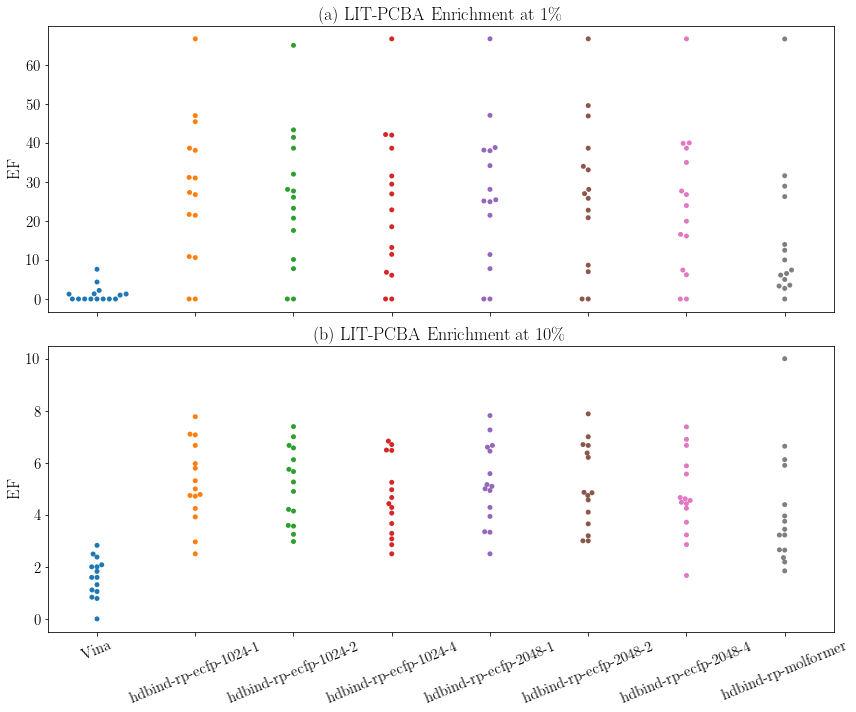

In [17]:
make_box_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

- should add the average EF (median?) to the labels on the horizontal axis

In [18]:
def make_swarm_plot(enrich_1_df, enrich_10_df):

    enrich_f, enrich_ax = plt.subplots(2,1, figsize=(12,10), sharex=True, sharey=False)
    enrich_ax = enrich_ax.flatten()
    enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
    sns.swarmplot(data=enrich_1_df, x="model", y="enrich", ax=enrich_1_ax, palette=color_dict)
    enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
    enrich_1_ax.set_xlabel("")
    enrich_1_ax.set_ylabel("")
    enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

    enrich_1_ax.set_ylabel("EF")

    plt.tight_layout()

    
    sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
    enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
    enrich_10_ax.set_xlabel("")
    enrich_10_ax.set_ylabel("")
    enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
    labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
    labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
    enrich_10_ax.set_xticklabels(labels)
    enrich_ax[0].set_ylabel("EF")
    enrich_ax[1].set_ylabel("EF")

    plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
    enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f

NameError: name 'color_dict' is not defined

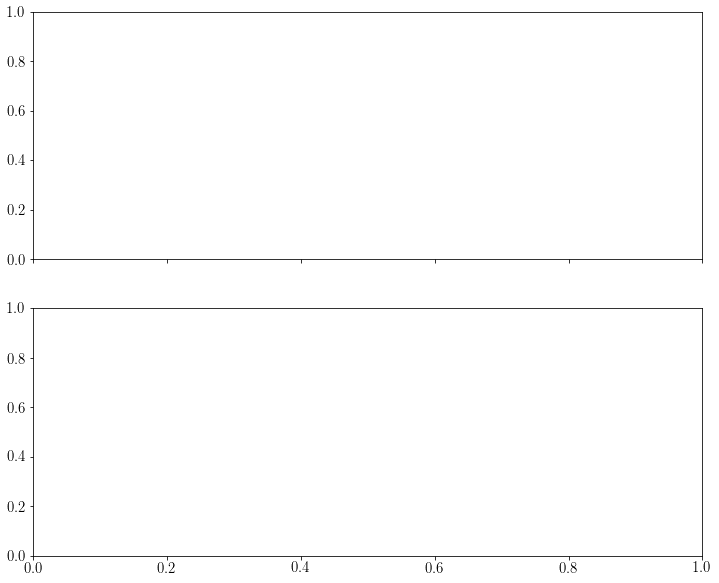

In [19]:
make_swarm_plot(enrich_1_df=grp_df[grp_df["p"] == .01], 
          enrich_10_df=grp_df[grp_df["p"] == .1])

In [ ]:
grp_df

In [ ]:
from pandas.plotting import parallel_coordinates

def make_pc_plot(df):

#     f, ax = plt.subplots(1,1, figsize=(12,10), sharex=True, sharey=False)

    df_list = list(df.groupby(["model"]))
    print(df_list)
#     pc_df = pd.concat([group_df for group_name, group_df in df.groupby('model')], axis=1)

    

#     ax = ax.flatten()
#     enrich_1_ax, enrich_10_ax = enrich_ax[0], enrich_ax[1]
    
#     sns.swarmplot(data=model_1_df, x="model", y="enrich", ax=ax, palette=color_dict)
#     enrich_1_ax.set_title("(a) LIT-PCBA Enrichment at 1\%", fontdict={"fontsize": 18})
#     enrich_1_ax.set_xlabel("")
#     enrich_1_ax.set_ylabel("")
#     enrich_1_ax.tick_params(axis="x", labelrotation=22.5)

#     enrich_1_ax.set_ylabel("EF")

#     plt.tight_layout()

    
#     sns.swarmplot(data=enrich_10_df, x="model", y="enrich", ax=enrich_10_ax, palette=color_dict)
#     enrich_10_ax.set_title("(b) LIT-PCBA Enrichment at 10\%", fontdict={"fontsize": 18})
#     enrich_10_ax.set_xlabel("")
#     enrich_10_ax.set_ylabel("")
#     enrich_10_ax.tick_params(axis="x", labelrotation=22.5)
#     labels = [item.get_text() for item in enrich_10_ax.get_xticklabels()]
#     labels = [model_name_dict[x.get_text()] for x in enrich_10_ax.get_xticklabels()]
#     labels[-1] = combo_model_name
#     enrich_10_ax.set_xticklabels(labels)
#     enrich_ax[0].set_ylabel("EF")
#     enrich_ax[1].set_ylabel("EF")

#     plt.tight_layout()
    # enrich_10_f.savefig("enrich_10.png", dpi=600, bbox_inches="tight")
    # enrich_10_f
    
#     enrich_f.savefig("lit-pcba-enrich-swarm.png", dpi=600, bbox_inches="tight")

#     return enrich_f
make_pc_plot(grp_df[grp_df["model"].apply(lambda x: x in  ["HDC-RF", "rf", "ecfp"])])

# Speedup

In [ ]:
def aggregate_time_results(dataset, range_limit=10):
    

    model_time_dict = {"model": [], "target": [], "seed": [],"train_time": [], "test_time": [], "train_size": [], "test_size": []}
    
    
    tokenizer="atomwise"
    ngram_order=0
    for model, color in tqdm(color_dict.items(), total=len(color_dict), position=0):
                        
        metric_list = []
        test_time_list = []
        train_size_list = []
        test_size_list = []
        target_size_list = []
        eta_list = []

        
        if model not in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.{model}*pkl"))

        elif model in ["HDC-MLP", "HDC-RF"]:
            data_path_list = list(data_p.glob(f"{dataset.replace('-','_')}*.ecfp*pkl"))
    
        for path in tqdm(data_path_list, total=len(data_path_list), position=1):

            
            with open(path, "rb") as handle:
                model_data_dict = pickle.load(handle)

            
            target = path.name.split(".")[1]
            
            tqdm.write(f"{target}, {path}, {model}")

            hd_cache_dir = f"/p/lustre2/jones289/hd_cache/125/ecfp/{dataset}/random"

            for seed in range(range_limit):
                    
                model_time_dict["model"].append(model)
                model_time_dict["target"].append(target)
                model_time_dict["seed"].append(seed)
                model_time_dict["train_time"].append(model_data_dict[seed]["train_time"])
                model_time_dict["test_time"].append(model_data_dict[seed]["test_time"])
                model_time_dict["train_size"].append(model_data_dict[seed]["train_size"])
                model_time_dict["test_size"].append(model_data_dict[seed]["test_size"])

                



    return model_time_dict
        


In [ ]:
time_dict = aggregate_time_results(dataset="lit-pcba", range_limit=10)
time_df = pd.DataFrame(time_dict)

In [ ]:
time_df["test_latency"] = time_df.apply(lambda x: x["test_time"]/x["test_size"], axis=1)

## averaging over seeds

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index()

## averaging over both seeds and target dimensions

In [ ]:
time_df.groupby(["model", "target"])["test_latency"].mean().reset_index().groupby("model")["test_latency"].median().reset_index()

In [ ]:
sns.boxplot(x="model", y="test_latency", data=time_df.groupby(["model", "target"])["test_latency"].mean().reset_index())